# The Boolean Pandemic
## Who is more likely to survive to the boolean pandemic?

# Overview
On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a **predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?”** using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can **predict if a patient will survive, or not**, to the boolean pandemic?

# Objective
The goal of your team is to predict if a patient is going to survive, or not, on the test set by using the model you created on the training set. The score of your predictions is the percentage of instances you correctly predict, using the **accuracy**. You are allowed to apply any kind of classifier!

# Evaluation
The project will be evaluated taking into account the following criteria:
- Model accuracy;
- The quality of the data exploration, pre-processing, modelling and assessment steps;
- Contributions based on self-study and creativity will be valued;
- The notebook structure and the conclusions / insights / review / justification of techniques of the developed processes in each of the stages of the process. For example, after the data exploration phase, you should write down at the end of this topic in markdown the main insights that you gather from the data during this phase.

# Deliverables
You should submit a csv file with the number of instances in the test set, containing the columns [Patient_ID, Deceased], and only those columns. The Deceased column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

# Metadata (corrected)
- *Patient_ID* - The unique identifier of the patient
- *Family_Case_ID* - The family identification
- *Severity* - The severity of the disease, where 1 is the lowest and 3 the highest severity
- *Name* - The name of the patient
- *Birthday_year* - The year of birthday of the patient
- *Parents_Children_Infected* - The number of parents and/or children infected
- *Partner_Siblings_Infected* - The number of partner and/or siblings infected
- *Medical_Expenses_Family* - The medical expenses associated to try to contain the epidemy on the family
- *Medical_Tent* - The medical tent where the patient is / was lodged
- *City* - The original city of the patient
- *Deceased* - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

# Import Packages and Data

In [2]:
import zipfile as zp
from math import ceil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df_list = []
for file in ["train.csv", "test.csv"]:
    with zp.ZipFile("./data.zip") as myzip:
        with myzip.open(file) as myfile:
            df_list.append(pd.read_csv(myfile))
            
train_df, test_df = df_list

# Data Assessment

In [4]:
print('There are ', train_df.shape[0], 'rows and ', train_df.shape[1], 'columns on the train set.')
print('There are ', test_df.shape[0], 'rows and ', test_df.shape[1], 'columns on the test set.')

There are  900 rows and  11 columns on the train set.
There are  400 rows and  10 columns on the test set.


Renaming some variables to make the code easier to write.

In [5]:
train_df.rename({"Parents or siblings infected": "Parents_Siblings_Infected", "Wife/Husband or children infected": "Partner_Children_Infected"}, axis=1, inplace=True)
test_df.rename({"Parents or siblings infected": "Parents_Siblings_Infected", "Wife/Husband or children infected": "Partner_Children_Infected"}, axis=1, inplace=True)

In [6]:
train_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Siblings_Infected,Partner_Children_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [7]:
test_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Siblings_Infected,Partner_Children_Infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


### Duplicates
No duplicates

In [8]:
# Check duplicates with all columns
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [9]:
# Check duplicates excluding Patient_ID
train_df.duplicated(subset=train_df.columns[1:]).sum(), test_df.duplicated(subset=test_df.columns[1:]).sum()

(0, 0)

In [10]:
# Check duplicates excluding Patient_id and Family_Case_ID
train_df.duplicated(subset=train_df.columns[2:]).sum(), test_df.duplicated(subset=test_df.columns[2:]).sum()

(0, 0)

In [11]:
# Check duplicates excluding Patient_id and Family_Case_ID and City
train_df.duplicated(subset=train_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum(),\
test_df.duplicated(subset=test_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum()

(0, 0)

### Index and Data Types

In [12]:
train_df.set_index("Patient_ID", inplace=True)
test_df.set_index("Patient_ID", inplace=True)

In [13]:
train_df.dtypes

Family_Case_ID                 int64
Severity                       int64
Name                          object
Birthday_year                float64
Parents_Siblings_Infected      int64
Partner_Children_Infected      int64
Medical_Expenses_Family        int64
Medical_Tent                  object
City                          object
Deceased                       int64
dtype: object

### Numerical Statistics

In [14]:
descriptive = train_df.describe().T
descriptive['nulls'] = train_df.shape[0] - descriptive['count']
descriptive

,count,mean,std,min,25%,50%,75%,max,nulls
Family_Case_ID,900.0,14305.827778,25418.153900,345.0,8203.0,13593.5,18906.50,742836.0,0.0
Severity,900.0,2.313333,0.834223,1.0,2.0,3.0,3.00,3.0,0.0
Birthday_year,723.0,1990.266943,14.523335,1940.0,1982.0,1992.0,1999.50,2019.0,177.0
Parents_Siblings_Infected,900.0,0.380000,0.803247,0.0,0.0,0.0,0.00,6.0,0.0
Partner_Children_Infected,900.0,0.521111,1.098385,0.0,0.0,0.0,1.00,8.0,0.0
Medical_Expenses_Family,900.0,895.743333,1385.829926,0.0,221.0,405.0,861.25,14345.0,0.0
Deceased,900.0,0.614444,0.486997,0.0,0.0,1.0,1.00,1.0,0.0


**Insights:** 
- Outliers: Medical_Expenses_Family, Partner_Siblings_Infected, Parents_Children_Infected
- Transform Birthday_year in Age
- Nulls: Birthday_year

### Categorical Statistics

In [15]:
descriptive = train_df[['Name','Medical_Tent', 'City']].describe().T
descriptive['nulls'] = train_df[['Name','Medical_Tent', 'City']].shape[0] - descriptive['count']
descriptive

,count,unique,top,freq,nulls
Name,900,899,Mr. Samuel Darnell,2,0
Medical_Tent,198,8,C,57,702
City,898,3,Santa Fe,649,2


**Insights:** 
- Name might not seem valueable, however we can analyze titles to find out features such as gender, married, etc.
- Maybe the nulls in Medical_Tent mean that they treated the disease at home or the tent is just not known (maybe replace nulls by "Home" or "NotKnown" and assess its discriminancy according to the target)

In [16]:
train_df.isna().sum(axis=1).value_counts()

1    565
0    177
2    158
dtype: int64

### Label Counts
Balanced dataset

In [17]:
train_df['Deceased'].value_counts()

1    553
0    347
Name: Deceased, dtype: int64

# Data Exploration

##### Family Size Frequency

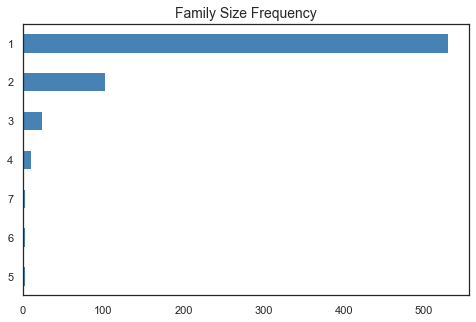

In [18]:
# Data leakage by ignoring family relationships? Familiar relationships make that observations in test set might not be independent from ones in the training set.
# Candidate for GroupKFold and GroupSplit.
sns.set(style="white")

plt.figure(figsize=(8, 5))
train_df["Family_Case_ID"].value_counts().value_counts(ascending=True).plot(kind="barh", color='steelblue')
plt.title("Family Size Frequency", fontsize=14)
plt.show()

We can see above that we have several individuals from the same family in our data. This can potentially cause some leakage if our data partitions (train-test split and cross-validation) don't preserve the individuals from the same family in the same partition, which in turn would lead to a biased estimate of the generalization capability of the model on the test set. However, it is also possible that after deployment we may find a relative of one of the patients used to train the model, which justifies the non-necessity of doing a constraint data partition process, as relatives in the test set represent a common situation in the real world.

#### Comment about why we dind't do train-test split!!!!!!

In [19]:
# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City", "Deceased"]  # low cardinality and categorical variables
metric_features = train_df.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list() + ["Deceased"]  # metric variables

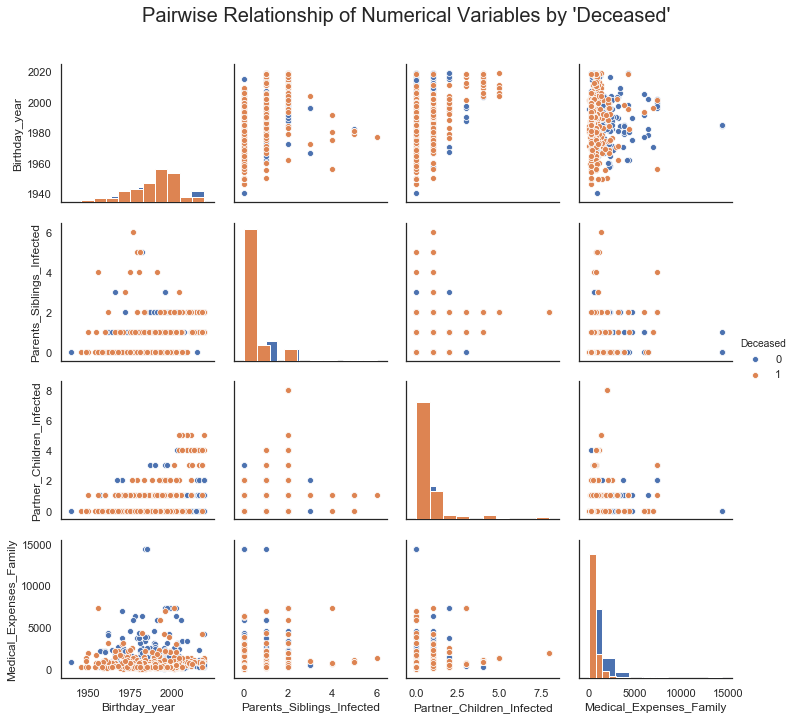

In [23]:
# data to plot
sns.set(style="white")

# Setting pairgrid
g = sns.pairplot(train_df[metric_features], hue="Deceased", diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.9)
plt.suptitle("Pairwise Relationship of Numerical Variables by 'Deceased'", fontsize=20)
plt.show()

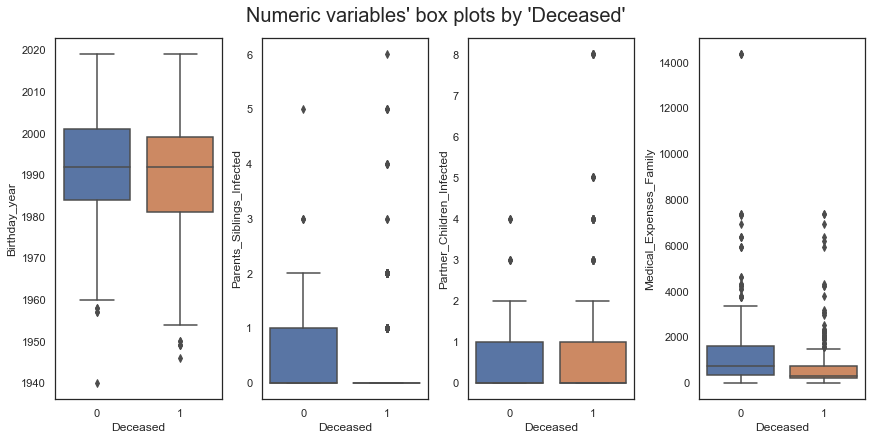

In [33]:
sns.set(style="white")

# features to plot
plot_features = metric_features
plot_features.remove("Deceased")

# Prepare figure
fig, axes = plt.subplots(1, len(plot_features), figsize=(12,6), constrained_layout=True)
    
# Plot data
for ax, f in zip(axes.flatten(), plot_features):
    sns.boxplot(y=f, data=train_df, ax=ax, x='Deceased')

# Layout
plt.suptitle("Numeric variables' box plots by 'Deceased'", fontsize=20)

plt.show()

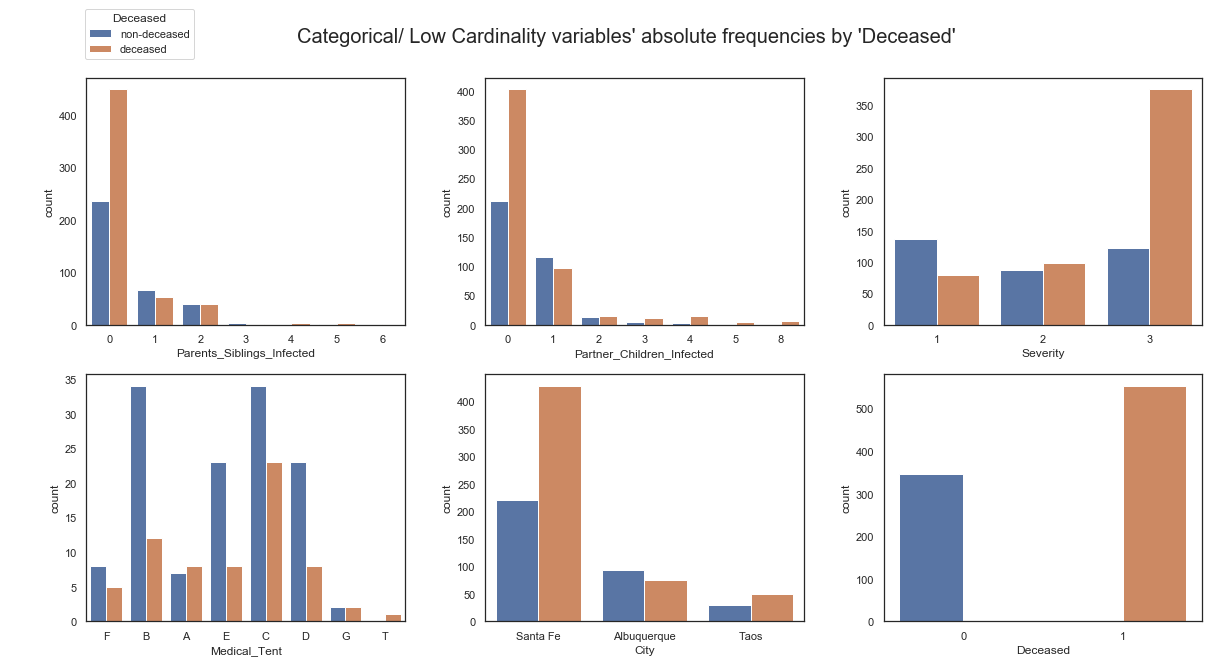

In [34]:
sns.set(style="white")

# data to plot
plot_df = train_df[lc_c_features + ["Parents_Siblings_Infected", "Partner_Children_Infected"]]
plot_features = ["Parents_Siblings_Infected", "Partner_Children_Infected"] + lc_c_features

# figure and axes
fig, axes = plt.subplots(2, ceil(len(plot_features)/2), figsize=(20,10))

# plot data
for ax, x in zip(axes.flatten(), plot_features):
    if x == "Deceased":
        sns.countplot(x=x, hue="Deceased", order=[0, 1], data=plot_df, ax=ax)
    else:
        sns.countplot(x=x, hue="Deceased", data=plot_df, ax=ax)
    ax.get_legend().remove()
    
# Set legend (Deceased)
handles, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ["non-deceased", "deceased"], loc=(0.07,0.91), title="Deceased", title_fontsize=12)

plt.subplots_adjust(wspace=0.25)
plt.suptitle("Categorical/ Low Cardinality variables' absolute frequencies by 'Deceased'", y=0.95, fontsize=20)

plt.show()

## Takeaways
- *Univariate outliters*: Medical_Expenses_Family, Parents_Children_Infected (should we keep values above 2?), Partner_Siblings_Infected (should we keep values above 2?).
- *Bivariate outliers*: There might be some by visualizing the bivariate scatter plots. Multivariate outlier detection could be applied.
- *High cardinality*: Medical_tent (there are some values with low presence)

Parents_Siblings_Infected and Partner_Children_Infected Frequency
- Low frequency of values 2, 4, 5 and 6 in Parents_Children_Infected
- Low frequency of values from 2 to 8 in Partner_Siblings_Infected
- There's the possibility to aggregate categories with low cardinality

##### Birthday_year and Medical_Expenses_Family Expressivness

In [20]:
# To visualize correctly the family_medical_expenses scatter plot, we should not take into account family members 
# that have the exact same value in medical expenses because we are duplicating information
tmp_df = train_df.copy()
tmp_df.drop_duplicates(subset=['Family_Case_ID','Medical_Expenses_Family'], inplace=True, ignore_index=True)
tmp_df.shape

(689, 10)

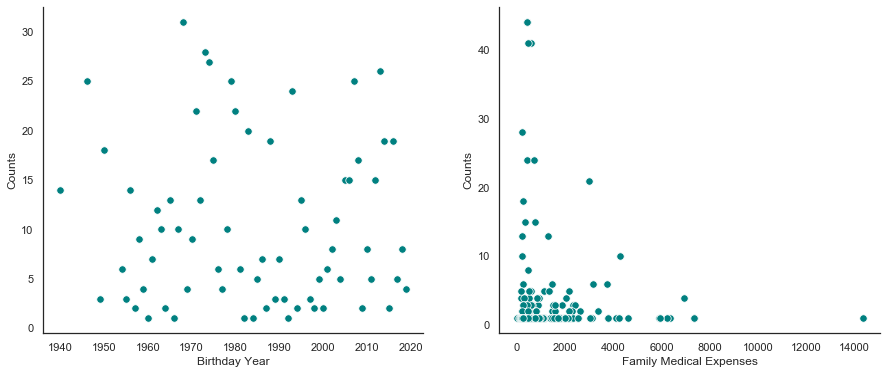

In [21]:
# Visualize the variables Birthday_year and Medical_Expenses_Family
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sev1 = sns.scatterplot(x=train_df['Birthday_year'].dropna().unique(), 
                      y=train_df.groupby('Birthday_year')['Family_Case_ID'].count(), color='teal', s=55, ax=axes[0])
sev1.set(xlabel='Birthday Year', ylabel='Counts')
sev1.grid(False)

sev2 = sns.scatterplot(
    x=tmp_df.Medical_Expenses_Family.dropna().unique(), 
    y=tmp_df.groupby('Medical_Expenses_Family')['Family_Case_ID'].count(), 
    color='teal', s=55, ax=axes[1])
sev2.set(xlabel='Family Medical Expenses', ylabel='Counts')
sev2.grid(False)

sns.set(rc={'figure.figsize':(15, 5)}, style="whitegrid")
sns.despine(top=True, right=True, left=False, bottom=False)
sns.set_style("ticks")

In [22]:
counts = tmp_df[(tmp_df['Medical_Expenses_Family'] <= 5000)].groupby('Medical_Expenses_Family')['Family_Case_ID'].count()
counts[counts > 30]

Medical_Expenses_Family
217    41
221    44
225    44
364    41
Name: Family_Case_ID, dtype: int64

Everything seems completely fine within a normal data values.

## Coherence Checks
There doesn't seem anyhting wrong with the data in terms of coherency.

# Data Cleaning
In this section we will clean our data using a copy of our train data. After having decided on some preprocessing steps (e.g. missing value imputer, scalling) we will integrate them in the pipeline and tune their parameters with grid-search.

In [34]:
# Getting X_train and y_train
X_train, y_train = train_df.drop(columns='Deceased'), train_df.Deceased 
# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City"]  # low cardinality and categorical variables
metric_features = X_train.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list()  # metric variables

## Outliers

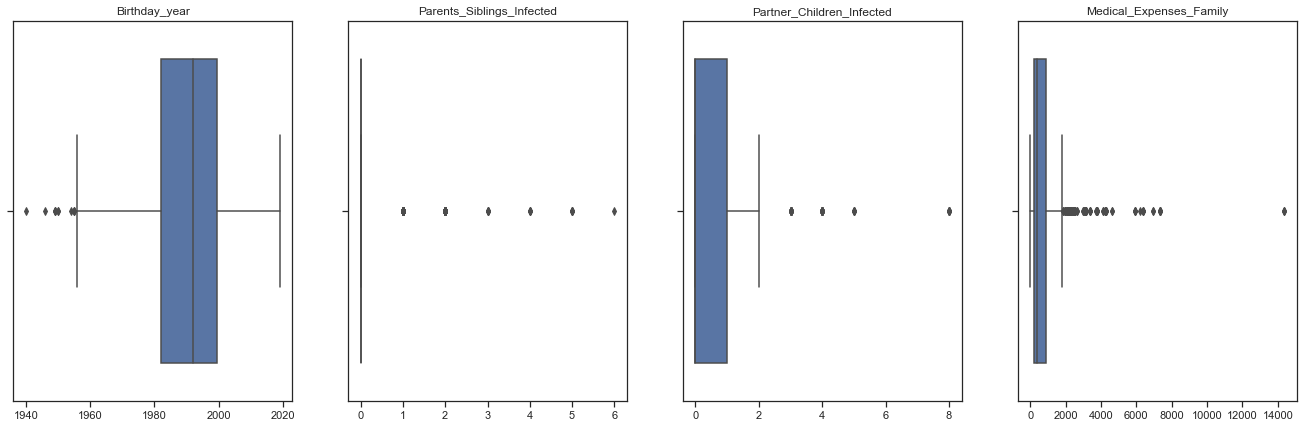

In [35]:
# 4 metric variables
fig = plt.figure(figsize=(23,7))
for i, var in enumerate(metric_features):
        i += 1
        plt.subplot(1,4,i)
        sns.boxplot(X_train[var])
        plt.title(var)
        plt.xlabel('')

In [36]:
# There are 3 observations with Medical_Expenses_Family above 8000 (all from the same family)
X_train[(X_train["Medical_Expenses_Family"] > 8000)]

,Family_Case_ID,Severity,Name,Birthday_year,Parents_Siblings_Infected,Partner_Children_Infected,Medical_Expenses_Family,Medical_Tent,City
Patient_ID,,,,,,,,,
17,8608,1,Mr. Laurence Salvador,1984.0,1,0,14345,B,Albuquerque
301,8608,1,Mr. Norman Wayne,1985.0,0,0,14345,B,Albuquerque
621,8608,1,Ms. Geraldine Toni,1985.0,0,0,14345,NaN,Albuquerque


Although we belive this observations can be potential outliers, we will first normalize the variable by taking into acccount the family size as this may prove that this observations are not outliers at all. So we will analyze the outliers for this variable after feature engineering.

## Missing Values
There are 3 variables that we have to treat regarding missing values. They are Birthday_year, Medical_Tent and City.

In [40]:
X_train.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Siblings_Infected      0
Partner_Children_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 702
City                           2
dtype: int64

#### City
There are only 2 null values in City so we decided to replace them with the mode, Santa Fe, that stands for the city of 72% of the patients.

In [48]:
X_train.City.value_counts()

Santa Fe       651
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [49]:
X_train.City.fillna(value="Santa Fe", inplace=True)

#### Medical_Tent

In [50]:
f"{round(562/720*100,2)}% of the observations have no value in Medical_Tent. The first thought is dropping the variable but on a second thought, the nulls in Medical_Tent may mean that they treated the disease at home. Or maybe the tent is just not known, we would have to ask the data owner to be sure, but for now we will replace the null values for 'Not Known' and then assess the variable discriminating power according to the target."

"78.06% of the observations have no value in Medical_Tent. The first thought is dropping the variable but on a second thought, the nulls in Medical_Tent may mean that they treated the disease at home. Or maybe the tent is just not known, we would have to ask the data owner to be sure, but for now we will replace the null values for 'Not Known' and then assess the variable discriminating power according to the target."

In [51]:
X_train.Medical_Tent = X_train.Medical_Tent.fillna(value="Not Known")

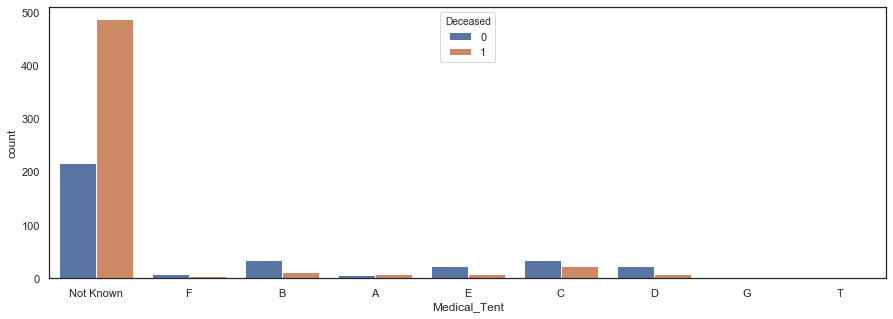

In [53]:
sns.countplot(x="Medical_Tent", hue=y_train, data=X_train)
plt.show()

#### Birthday_year

In [60]:
X_train.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Siblings_Infected      0
Partner_Children_Infected      0
Medical_Expenses_Family        0
Medical_Tent                   0
City                           0
dtype: int64

We have 177 null values in the Birthday_year column. We consider this attribute gives us important information to predict the final outcome of the disease, so dropping the column is not an option and we have to think on the best way of imputting these values.<br>
Using a mean, median or mode doesn't make sense in this case, so we decided to use KNN imputter. When thinking on which attributes to use in the KNN, we concluded they shouldn't all be included. We believe Family_Case_ID, Name, City, Medical_Expenses_Family and Medical_Tent give us no information on the birthday year of a patient, on the other hand, knowing if the person has siblings/parents infected, partner/children infected and the severity of the desease can possibly help us in this task.<br><br>

In [64]:
def scale_function(X_data, columns_to_norm, columns_not_norm, scaler_type, scaler=None):
    '''Function to apply normalization. 
    When the function is called to be applied in the test set, it receives an already fitted scaler.'''
    
    if scaler_type=='MinMaxScaler':
        if scaler is None:
            scaler = MinMaxScaler().fit(X_data[columns_to_norm])
        X_scaled = scaler.transform(X_data[columns_to_norm])
        
    else:
        if scaler is None:
            scaler = StandardScaler().fit(X_data[columns_to_norm])
        X_scaled = scaler.transform(X_data[columns_to_norm])
        
    X = np.append(X_data[columns_not_norm], X_scaled, axis=1)
    X = pd.DataFrame(X, columns = columns_not_norm+columns_to_norm)

    return X, scaler

In [65]:
scaler_type="StandardScaler"

In [66]:
def knn_imputer_birthday(X, scaler_type):
    X_use = X.copy()
    fill_birthday, scaler = scale_function(X_use.drop(columns=['Family_Case_ID','Name','Medical_Expenses_Family','Medical_Tent','City']),
                         columns_to_norm=['Severity','Parents_Siblings_Infected','Partner_Children_Infected'],
                         columns_not_norm=['Birthday_year'],
                         scaler_type=scaler_type)

    imputer = KNNImputer(n_neighbors=3)
    X_imputted_birthday = imputer.fit_transform(fill_birthday)
    X_use.Birthday_year = list(pd.DataFrame(X_imputted_birthday).iloc[:,0]) # 0 is the index of Birthday_year
    return X_use

In [67]:
X_train = knn_imputer_birthday(X_train, scaler_type=scaler_type)

In [68]:
X_train.isnull().sum()

Family_Case_ID               0
Severity                     0
Name                         0
Birthday_year                0
Parents_Siblings_Infected    0
Partner_Children_Infected    0
Medical_Expenses_Family      0
Medical_Tent                 0
City                         0
dtype: int64

## Feature Engineering

In [126]:
X_train["Medical_Tent_Binary"] = X_train["Medical_Tent"].map(lambda x: x if x == "Not Known" else "Known")
X_train["Age"] = X_train["Birthday_year"].map(lambda x: 2020 - x) # Age instead of Birth_year
X_train["Pediatric_Binary"] = X_train["Age"].map(lambda x: 1 if x < 18 else 0) # if it's considered a pediatric case, may receive different attention
X_train["3rd_Age_Binary"] = X_train["Age"].map(lambda x: 1 if x >= 65 else 0) # if it's considered a third age case, may receive less care in case of medical overwhelming
X_train['Title'] = X_train['Name'].str.split('\\W', 1, expand=True)[0] # We can analyze Name and obtain Title and Gender and Married
X_train['Gender'] = X_train['Title'].map(lambda x: "Male" if x in ["Mr", "Master"] else "Female")  # Get gender based on title
X_train['Parents_Siblings_Infected_Binary'] = X_train['Parents_Siblings_Infected'].map(lambda x: 0 if x==0 else 1)  # Get binary
X_train['Partner_Children_Infected_Binary'] = X_train['Partner_Children_Infected'].map(lambda x: 0 if x==0 else 1)  # Get binary

familycount = X_train.Family_Case_ID.value_counts().to_dict()
X_train["Family_Infected"] = X_train["Family_Case_ID"].map(familycount)  # how many family members in record as infected ,1 equals only the patient
del familycount

X_train_w_dec = pd.concat([X_train, y_train], axis=1)
deceasedfamcount = X_train_w_dec.loc[X_train_w_dec['Deceased']==1].Family_Case_ID.value_counts().to_dict()
X_train["Family_Deceased"] = (X_train["Family_Case_ID"].map(deceasedfamcount)-1).fillna(0)  # how many other family members in record as deceased
del deceasedfamcount

X_train["Family_Infected_Binary"] = X_train["Family_Infected"].map(lambda x: 0 if x==1 else 1)
X_train["Dead_infected_ratio_family"] = X_train["Family_Deceased"] / X_train["Family_Infected"]  # ratio of known deaths in the family
X_train["Medical_Expenses_Individual"] = X_train["Medical_Expenses_Family"] / X_train["Family_Infected"]

In [93]:
# Possible incoherency:
((X_train["Family_Infected"] - 1) - X_train[["Parents_Siblings_Infected", "Partner_Children_Infected"]].sum(axis=1)).value_counts().sort_index()

-6      1
-4      8
-3      8
-2     39
-1    131
 0    596
 1     73
 2     25
 3      9
 4      3
 6      7
dtype: int64

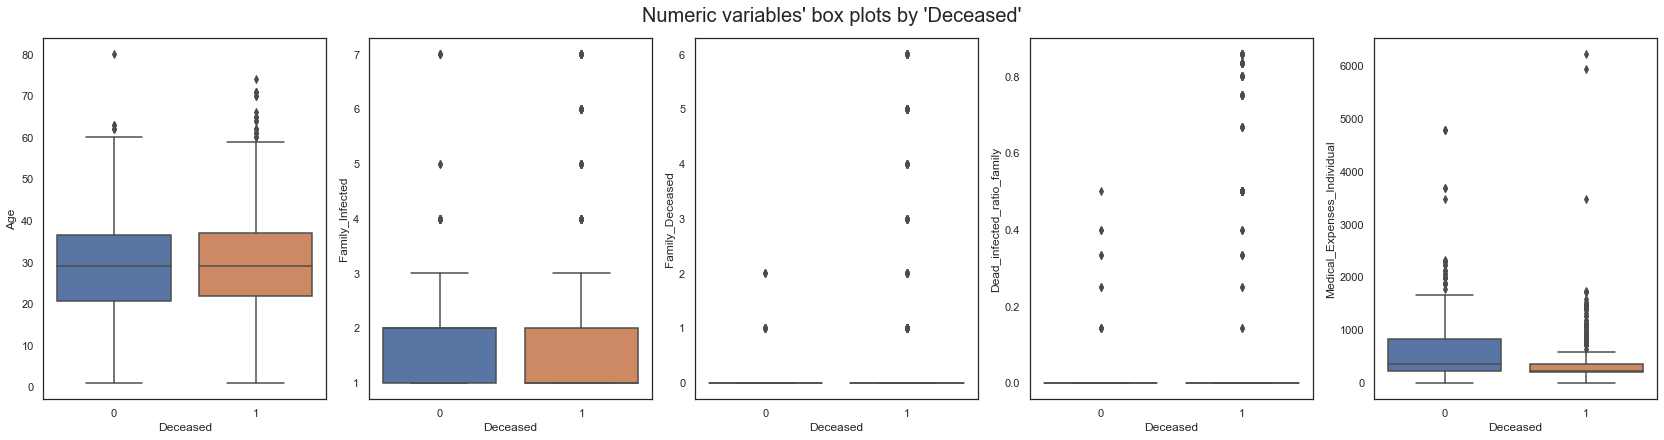

In [122]:
sns.set(style="white")

plot_features = ["Age", "Family_Infected", "Family_Deceased", "Dead_infected_ratio_family", "Medical_Expenses_Individual"]

# plot df
plot_df = pd.concat([X_train[plot_features], y_train], axis=1)

# Prepare figure
fig, axes = plt.subplots(1, len(plot_features), figsize=(23,6), constrained_layout=True)
    
# Plot data
for ax, f in zip(axes.flatten(), plot_features):
    sns.boxplot(y=f, data=plot_df, ax=ax, x='Deceased')

# Layout
plt.suptitle("Numeric variables' box plots by 'Deceased'", fontsize=20)

plt.show()

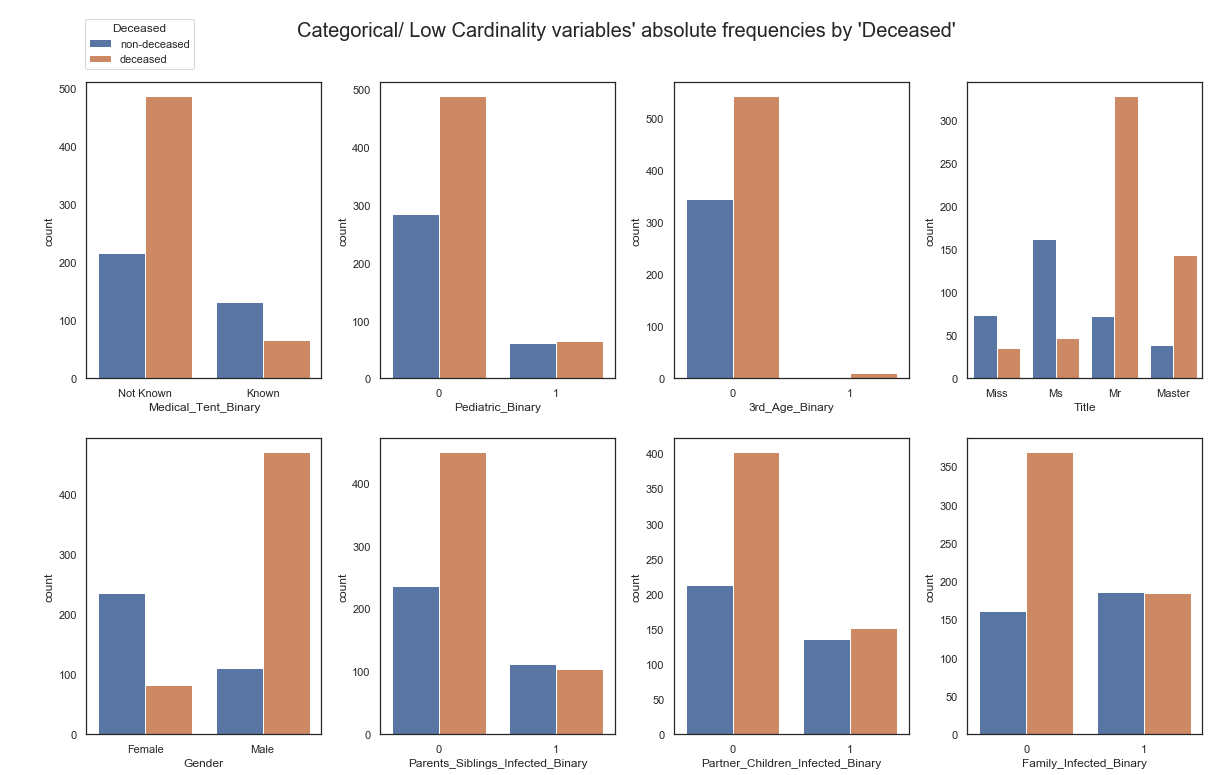

In [127]:
# data to plot

plot_features = ["Medical_Tent_Binary", "Pediatric_Binary", "3rd_Age_Binary", "Title", "Gender", "Parents_Siblings_Infected_Binary", "Partner_Children_Infected_Binary", "Family_Infected_Binary"]

plot_df = pd.concat([X_train[plot_features], y_train], axis=1)

# figure and axes
fig, axes = plt.subplots(2, ceil(len(plot_features)/2), figsize=(20,12))

# plot data
for ax, x in zip(axes.flatten(), plot_features):
    if x == "Deceased":
        sns.countplot(x=x, hue="Deceased", order=[0, 1], data=plot_df, ax=ax)
    else:
        sns.countplot(x=x, hue="Deceased", data=plot_df, ax=ax)
    ax.get_legend().remove()
    
# Set legend (Deceased)
handles, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ["non-deceased", "deceased"], loc=(0.07,0.91), title="Deceased", title_fontsize=12)

plt.subplots_adjust(wspace=0.25)
plt.suptitle("Categorical/ Low Cardinality variables' absolute frequencies by 'Deceased'", y=0.95, fontsize=20)

plt.show()

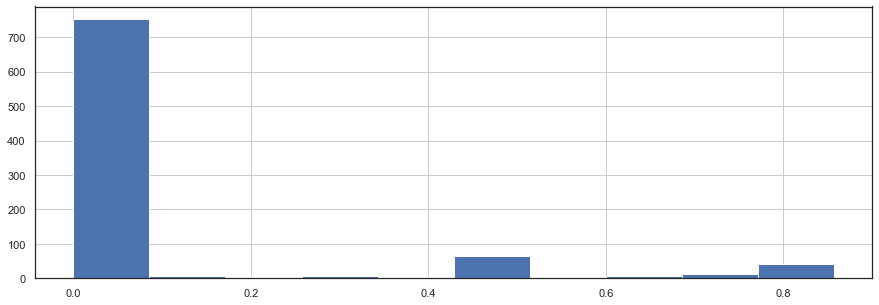

In [76]:
X_train["Dead_infected_ratio_family"].hist()
plt.show()

In [81]:
X_train["Title"].value_counts()

Mr        400
Ms        209
Master    182
Miss      109
Name: Title, dtype: int64

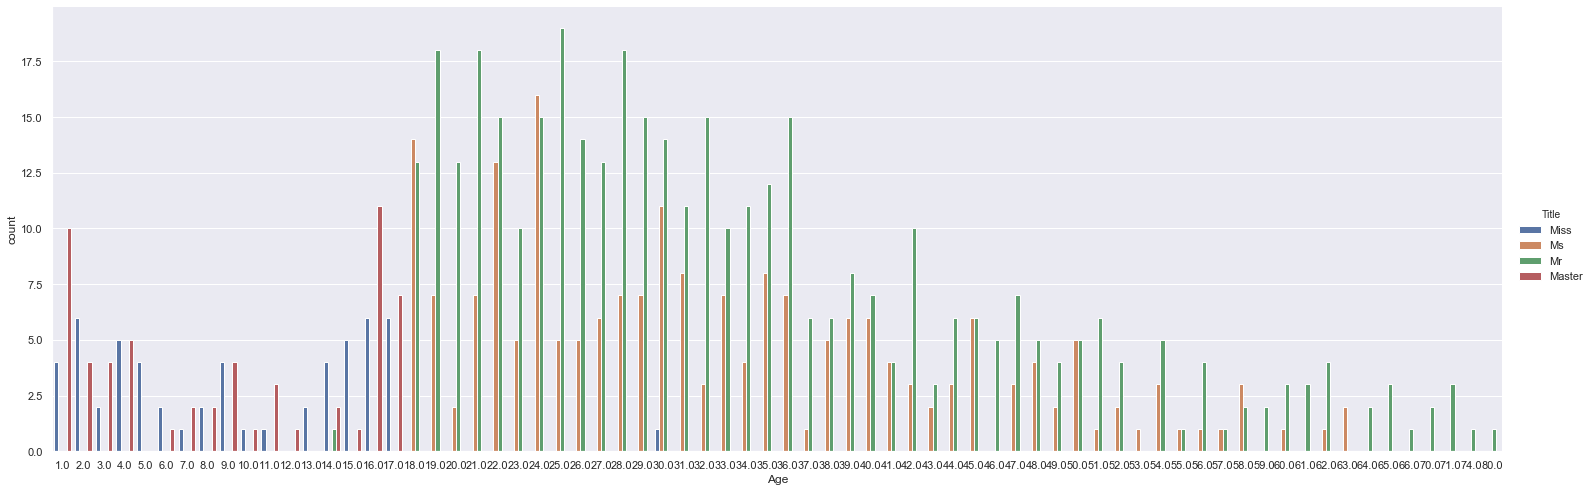

In [53]:
sns.set()

sns.catplot(x="Age", hue="Title",
               data=X_train, kind="count",
               height=7, aspect=3)
#sns.countplot(x="Age", hue="Title", data=X_train)
plt.show()

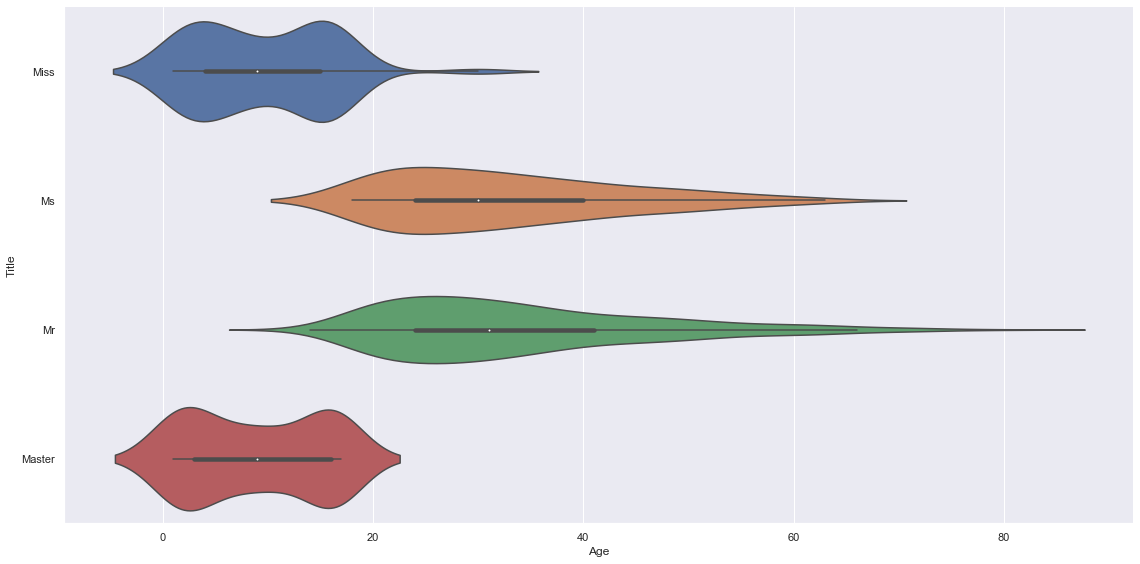

In [54]:
sns.set()

ax= sns.catplot(
    data=X_train,
    y='Title',
    x='Age',
    kind='violin',
    height=8, aspect=2)

plt.show()

We can only get gender from here, only in one case is the title used as a non-married female, but in many cases Ms is used without marital status implied. So we cannot assume marital status for all of the adults.
There's agreement between titles and ages except in two cases, Mister at 14, and Miss at 30s.


In [ ]:
# apply log to medical expenses, number family infected, is family infected

In [55]:
#Let's continue later with gender and such

## Assessment
Assess preprocessed data using visualizations. Check if problems are solved and if features are useful.

In [56]:
sns.set(style="white")

# Compute the correlation matrix
corr = train_df[metric_features].corr() #Getting correlation of numerical variables

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# # Pass 2D Numpy array to annot parameter
# mask_annot = np.absolute(corr.values)>=0.50 # Annotate correlations above abs(0.5)
# annot_arr = np.where(mask_annot, corr.values.round(2), np.full(corr.shape,""))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, annot=corr, ax=ax, vmin=-1, vmax=1)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Preprocessed data

In [57]:
# ensure all the data (train and test) is prepared for modelling (even though we will apply some preprocessing steps in the pipeline ahead, 
#     there are some stuff we need to do previously like ensure every dataset has all the features required).
X_train.drop(["Name"], axis=1, inplace=True)

# Modelling
In this section we will build our sklearn Pipeline and use it to find out the best hyperparameters according to the model accuracy. We will also use it to select the most appropriate classifier algorithm and do model comparision.

In [58]:
# Saving parameter grid for specific Grid Search run
class ComplexEncoder(json.JSONEncoder):  # This class is used to save the instance objects belonging to a grid as strings
    def default(self, obj):
        if isinstance(obj, (StandardScaler, MinMaxScaler, SelectFromModel, LogisticRegression, KNeighborsClassifier, GaussianNB, np.ndarray, NeighborhoodComponentsAnalysis, dict)):  # Include all classes that aren't serializable here
            return str(obj)
        # Let the base class default method raise the TypeError 
        return json.JSONEncoder.default(self, obj)
    

def gs_outputs(id_num, gscv_fitted, grid):
    """
    Function that saves information of each grid-search.
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    grid: takes the grid used to fit the GridSearchCV object
    
    Returns:
    top 20 configurations hyper-parameter presence graphic
    (also outputs the "logs" of each grid-search to the output directory)
    """
    
    # Saving parameter grid for specific Grid Search run
    with open("./outputs/grids.txt", "a") as file:
        file.write("# {}------------------------------------------------------ #\n".format(id_num) + json.dumps(grid, cls=ComplexEncoder) + "\n\n")

    # Saving cv_results for specific Grid Search run
    score_summary = pd.DataFrame(gscv_fitted.cv_results_).sort_values(by="mean_test_score", ascending=False)
    score_summary.to_csv("./outputs/grid_search_results{}.csv".format(id_num))
    
    # Assessing distribution of hyper-parameter values amongst top 20 models
    sns.set()

    # Features to plot
    plot_features = list(map(lambda x: "param_" + x, {i for j in range(len(grid)) for i in grid[j].keys()}))
    plot_df = score_summary.reset_index(drop=True).loc[:19, :].fillna("NaN")

    # figure and axes
    fig, axes = plt.subplots(3, ceil(len(plot_features)/3), figsize=(23,13))

    # plot data
    for ax, x in zip(axes.flatten(), plot_features):
        try:
            sns.countplot(x=x, data=plot_df, ax=ax)
        except TypeError:
            sns.countplot(x=plot_df[x].apply(json.dumps), ax=ax)

    plt.suptitle("Hyper-parameter presence on top 20 models", y=0.95, fontsize=25)

    plt.savefig("./outputs/grid_results{}.png".format(id_num))
    
    # Model training - using best parameters to train model on entire data for submission
    best_model = full_pipeline.set_params(**gscv_fitted.best_params_)
    best_model.fit(X, y)  # Using all of the data to fit the model

    # Predicting the 
    y_pred = best_model.predict(test_df)

    # Submission
    pd.DataFrame(data={"Employee_ID": test_df.index.to_list(), "Churn_risk": y_pred}).to_csv("./outputs/submission{}.csv".format(id_num), index=False)
    
    return plt.show()

NameError: name 'json' is not defined

In [ ]:
# Categrical features to pass down the categorical pipeline 
categorical_features = []  # COMPLETE

# Numerical features to pass down the numerical pipeline 
metric_features = X_train.columns.drop(categorical_features).to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps=[('impute_mode', SimpleImputer(strategy="most_frequent")),
                                       ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Defining the steps in the numerical pipeline     
std, minmax = StandardScaler(), MinMaxScaler()

# Combining numerical and categorical pipeline into one full big pipeline horizontally 
join_pipeline = ColumnTransformer(transformers=[('numerical_pipeline', "passthrough", metric_features),  # we will find out what's the best scaler in GS
                                                 ('categorical_pipeline', categorical_pipeline, categorical_features)])

# Imputing Missing values with normalized and one hot encoded data
imputer = KNNImputer()

# Finally, we will impute NaNs with KNNImputer and build our preprocessing pipeline
prep_pipeline = Pipeline(steps=[("join_features", join_pipeline),
                                ("imputer", imputer)])

# Feature Selection
fselect1 = SelectFromModel(LogisticRegression(penalty="l1", max_iter=400, multi_class="multinomial", solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C
fselect2 = NeighborhoodComponentsAnalysis(max_iter=25, tol=0.005, random_state=1)  # tune: n_components, tol=0.005 (it takes to long)
fselect3 = SelectFromModel(LogisticRegression(penalty="l2", max_iter=400,  multi_class="multinomial", solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C, threshold

# Model
lr = LogisticRegression(max_iter=400, multi_class="multinomial", n_jobs=-1, random_state=1)  # tune: penalty=['elasticnet'], l1_ratio=[0.2, 0.5, 0.8], C=[10.0 ** np.arange(-4, 2)], tol=[10.0 ** np.arange(-5, 0)], class_weight=['balanced', None], solver=['newton-cg', 'sag', 'saga' and 'lbfgs']

knn = KNeighborsClassifier(n_jobs=-1)  # tune: n_neighbors, weights, metric

# gnb = GaussianNB()

# Full pipeline with model
full_pipeline = Pipeline(steps=[("prep", prep_pipeline),  # 15 features outputed
                                ("fselect1", "passthrough"),
                                ("fselect2", "passthrough"),
                                ("model", "passthrough")])

grid = [  # COMPLETE
    {
        
    },
    {
        
    }
]

In [ ]:
# Instatiating GridSearch
gscv = GridSearchCV(full_pipeline, grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), scoring='f1_micro', verbose=1, n_jobs=-1)

In [ ]:
# Get ID of grid search
id_num = input("Insert GridSearch ID number: ")

# Grid Search and model training
gscv.fit(X_train, y_train)

# Obtain outputs from Grid Search
gs_outputs(id_num, gscv, grid)

In [ ]:
# Model training - using best parameters to train model on entire training set
best_params = gscv.best_params_
best_model = full_pipeline.set_params(**best_params)
best_model.fit(X_train, y_train)

# Model assessment
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print("TRAIN set F1-score(micro) is: {:.3f}\nTEST set F1-score(micro) is: {:.3f}".format(f1_score(y_train, y_train_pred, average='micro'), f1_score(y_test, y_test_pred, average='micro')))

# References
### Model selection and evaluation
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://weina.me/nested-cross-validation/
- https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
- https://www.elderresearch.com/blog/nested-cross-validation
- https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection
- https://scikit-learn.org/stable/modules/cross_validation.html
- On Over-fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation, Gavin C. Cawley, Nicola L. C. Talbot

### Topic here
- 